In [1]:
# All imports required are here
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys 
import os
import numpy as np
import cv2
from PIL import Image
from torch.utils.data import Dataset
import torch.utils.data as data
from torch.optim.lr_scheduler import StepLR
import time
import random

In [55]:
input_to_use = "CoOfFee" # make sure you have a folder named input with a subfolder named {input_to_use}
base_path = f'/home/nasseraa/inversion-analysis/focal_stacking/input'
folder_counter = f'{base_path}/{input_to_use}'
output_folder = f'output/{input_to_use}'
detect_misaligned_flag = False
resize_factor = 7

align_images_flag = True
get_masks_flag = True
use_aligned = True
experiment_name = "3D_Set_" + f'{input_to_use}'
sharpness = True
make_gif = False # disabling this will save up memory for larger images
# check and use cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)

device:  cuda


In [56]:
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]



class CustomImageDataset(Dataset):
    def __init__(self, data_dir, masks=None):
        self.data_dir = data_dir
        self.image_paths = []  # list of image file paths
        self.masks = masks  # list of masks
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        self.transform_mask = transforms.Compose([
            transforms.ToTensor(),
            # transforms.Normalize(0.5, 0.5)
        ])

        # Determine the size of the first image in the dataset
        sample_image_path = os.path.join(data_dir, os.listdir(data_dir)[0])
        sample_image = Image.open(sample_image_path)
        self.image_size = sample_image.size
        sample_image.close()

        for root, dirs, files in os.walk(data_dir):
            for file in files:
                if file.endswith(".jpg") or file.endswith(".png"):
                    self.image_paths.append(os.path.join(root, file))

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path)
        gt = self.transform_mask(image)

        # Resize image and mask based on the size of the first image in the dataset
        resize_transform = transforms.Resize((int(self.image_size[1]), int(self.image_size[0])))
        image = resize_transform(image)
        gt = resize_transform(gt)

        image = self.transform(image)

        if self.masks is not None:
            mask = self.masks[index]
            mask = Image.fromarray(mask.astype(np.uint8)*255)
            mask = resize_transform(mask)
            mask = self.transform_mask(mask)
            return image, gt, mask
        else:
            return image, gt, gt

    def __len__(self):
        return len(self.image_paths)
    
# helper functions


import glob

def count_files_in_folder(folder_path):
    # Get a list of all files and directories in the specified folder
    files = os.listdir(folder_path)

    # Count the number of files in the list
    count = 0
    for file in files:
        if os.path.isfile(os.path.join(folder_path, file)):
            count += 1

    return count

def load_images(folder_path):
    images = []
    for file in os.listdir(folder_path):
        img_paths = glob.glob(os.path.join(folder_path, file))
        for img_path in img_paths:
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
            else:
                print(f'Failed to read image at path {img_path}')
    return images

def findHomography(image_1_kp, image_2_kp, matches):
    image_1_points = np.zeros((len(matches), 1, 2), dtype=np.float32)
    image_2_points = np.zeros((len(matches), 1, 2), dtype=np.float32)

    for i in range(0,len(matches)):
        image_1_points[i] = image_1_kp[matches[i].queryIdx].pt
        image_2_points[i] = image_2_kp[matches[i].trainIdx].pt

    try:
        homography, mask = cv2.findHomography(image_1_points, image_2_points, cv2.RANSAC, ransacReprojThreshold=2.0)
    except:
        return None
    return homography

def align_images(images):

    #   SIFT generally produces better results, but it is not FOSS, so chose the feature detector
    #   that suits the needs of your project.  ORB does OK
    use_sift = True

    outimages = []

    if use_sift:
        detector = cv2.xfeatures2d.SIFT_create()
    else:
        detector = cv2.ORB_create(1000)

    #   We assume that image 0 is the "base" image and align everything to it
    print ("Detecting features of base image")
    outimages.append(images[0])
    image1gray = cv2.cvtColor(images[0],cv2.COLOR_BGR2GRAY)
    image_1_kp, image_1_desc = detector.detectAndCompute(image1gray, None)

    for i in range(1,len(images)):
        print ("Aligning image {}".format(i))
        image_i_kp, image_i_desc = detector.detectAndCompute(images[i], None)

        if use_sift:
            bf = cv2.BFMatcher()
            # This returns the top two matches for each feature point (list of list)
            pairMatches = bf.knnMatch(image_i_desc,image_1_desc, k=2)
            rawMatches = []
            for m,n in pairMatches:
                if m.distance < 0.7*n.distance:
                    rawMatches.append(m)
        else:
            bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
            rawMatches = bf.match(image_i_desc, image_1_desc)

        sortMatches = sorted(rawMatches, key=lambda x: x.distance)
        matches = sortMatches[0:128]



        hom = findHomography(image_i_kp, image_1_kp, matches)
        if hom is None:
            print("couldn't align image {}".format(i))
            newimage = images[i]
        else:
            newimage = cv2.warpPerspective(images[i], hom, (images[i].shape[1], images[i].shape[0]), flags=cv2.INTER_LINEAR)

        outimages.append(newimage)
        # If you find that there's a large amount of ghosting, it may be because one or more of the input
        # images gets misaligned.  Outputting the aligned images may help diagnose that.
        # cv2.imwrite("aligned{}.png".format(i), newimage)



    return outimages

def doLap(image):

    # YOU SHOULD TUNE THESE VALUES TO SUIT YOUR NEEDS
    kernel_size = 5         # Size of the laplacian window
    blur_size = 5           # How big of a kernal to use for the gaussian blur
                            # Generally, keeping these two values the same or very close works well
                            # Also, odd numbers, please...

    blurred = cv2.GaussianBlur(image, (blur_size,blur_size), 0)
    return cv2.Laplacian(blurred, cv2.CV_64F, ksize=kernel_size)

def doLapStack(aligned_images):
    print ("Computing the laplacian of the blurred images")
    laps = []
    for i in range(len(aligned_images)):
        print ("Lap {}".format(i))
        # print(aligned_images[i].shape, aligned_images[i].dtype, type(aligned_images[i]))
        laps.append(doLap(cv2.cvtColor(aligned_images[i],cv2.COLOR_BGR2GRAY)))
    laps = np.asarray(laps)


    # create mask
    abs_laps = np.absolute(laps)
    maxima = abs_laps.max(axis=0)
    bool_mask = abs_laps == maxima
    masks = bool_mask.astype(np.uint8)

    output = np.zeros(shape=aligned_images[0].shape, dtype=aligned_images[0].dtype)

    for i in range(0,len(aligned_images)):
        output = cv2.bitwise_not(aligned_images[i],output, mask=masks[i])
        
    result = 255-output

    return masks, result

# read images in folder
def read_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

def save_as_image(image, path, name):
    cv2.imwrite(os.path.join(path , name), image)

def progress_bar(current, total,extra_text , barLength = 20):
    percent = float(current) * 100 / total
    arrow = '-' * int(percent/100 * barLength - 1) + '>'
    spaces = ' ' * (barLength - len(arrow))

    print('Progress: [%s%s] %d %% || %s' % (arrow, spaces, percent, extra_text), end='\r')

def plot_loss(results, name, sharpness):
    epoch_list = []
    loss_list = []
    gt_loss_list = []
    
    if sharpness:
        sharpness_list = []
        sim_list = []
        alpha_list = []
        beta_list = []
        for epoch, output, loss, f_loss, s_loss, weights in results:
            epoch_list.append(epoch)
            loss_list.append(loss.item())
            sharpness_list.append(f_loss.item())
            sim_list.append(s_loss.item())
            # alpha_list.append(weights[0])
            # beta_list.append(weights[1])
        # output the lists into a txt file
        with open(f'output/{input_to_use}/{name}_loss.txt', 'w') as f:
            for i in range(len(epoch_list)):
                f.write(f'{epoch_list[i]},{loss_list[i]},{sharpness_list[i]},{sim_list[i]}\n')
    else:
        for epoch, output, loss, weights in results:
            epoch_list.append(epoch)
            loss_list.append(loss.item())

    if sharpness:
        plt.plot(epoch_list, sharpness_list, label='Sharpness')
        plt.plot(epoch_list, sim_list, label='Similarity Loss')
        # plt.plot(epoch_list, alpha_list, label='alpha')
        # plt.plot(epoch_list, beta_list, label='beta')
    else:
        plt.plot(epoch_list, loss_list, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Create a "results" folder if it doesn't exist
    if not os.path.exists('results'):
        os.makedirs('results')
    
    # Save the plot with the specified name
    name += f'_{epoch_list[-1]+1}'
    plt.savefig(f'output/{input_to_use}/{name}.png')
    
    plt.show()

misaligned_masks = []
def detect_misaligned_pixels(images, threshold=1.0):
    # Compute the optical flow between adjacent pairs of images
    flows = []
    print("type and shape of images: ", type(images), len(images))
    # convert images to greyscale
    images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]
    for i in range(len(images) - 1):
        flow = cv2.calcOpticalFlowFarneback(images[i], images[i+1], None, 0.5, 3, 15, 3, 5, 1.2, 0)
        flows.append(flow)

    # Compute the magnitude of the optical flow at each pixel
    flow_mags = [np.sqrt(np.sum(np.square(flow), axis=2)) for flow in flows]
    print("type and shape of flow_mags: ", type(flow_mags), len(flow_mags))

    # Threshold the flow magnitudes to identify misaligned pixels
    misaligned_masks = [flow_mag > threshold for flow_mag in flow_mags]
    print("type and shape of misaligned_masks: ", type(misaligned_masks), len(misaligned_masks))

    # Display the misaligned pixels on each image
    for i, img in enumerate(images):
        img_with_misaligned = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        for misaligned_mask in misaligned_masks:
            img_with_misaligned[misaligned_mask] = [0, 0, 255]  # mark misaligned pixels in red
        plt.imshow(img_with_misaligned)
        plt.title(f'Image {i+1} with misaligned pixels')
        plt.show()

There are 21 files in the folder.
Failed to read image at path /home/nasseraa/inversion-analysis/focal_stacking/input/CoOfFee/GT
Failed to read image at path /home/nasseraa/inversion-analysis/focal_stacking/input/CoOfFee/aligned
Failed to read image at path /home/nasseraa/inversion-analysis/focal_stacking/input/CoOfFee/cropped_3082
Failed to read image at path /home/nasseraa/inversion-analysis/focal_stacking/input/CoOfFee/cropped_1532
Failed to read image at path /home/nasseraa/inversion-analysis/focal_stacking/input/CoOfFee/cropped_1398
Failed to read image at path /home/nasseraa/inversion-analysis/focal_stacking/input/CoOfFee/cropped_1753
Failed to read image at path /home/nasseraa/inversion-analysis/focal_stacking/input/CoOfFee/cropped_2329
Failed to read image at path /home/nasseraa/inversion-analysis/focal_stacking/input/CoOfFee/cropped_3167
Failed to read image at path /home/nasseraa/inversion-analysis/focal_stacking/input/CoOfFee/cropped_2959
type and length of images:  <class '

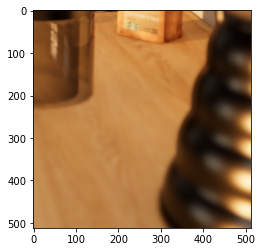

Failed to read image at path /home/nasseraa/inversion-analysis/focal_stacking/input/CoOfFee/cropped_2198/aligned
Failed to read image at path /home/nasseraa/inversion-analysis/focal_stacking/input/CoOfFee/cropped_2198/10.png
Failed to read image at path /home/nasseraa/inversion-analysis/focal_stacking/input/CoOfFee/cropped_2198/11.png
Failed to read image at path /home/nasseraa/inversion-analysis/focal_stacking/input/CoOfFee/cropped_2198/12.png
Failed to read image at path /home/nasseraa/inversion-analysis/focal_stacking/input/CoOfFee/cropped_2198/13.png
Failed to read image at path /home/nasseraa/inversion-analysis/focal_stacking/input/CoOfFee/cropped_2198/14.png
Failed to read image at path /home/nasseraa/inversion-analysis/focal_stacking/input/CoOfFee/cropped_2198/15.png
Failed to read image at path /home/nasseraa/inversion-analysis/focal_stacking/input/CoOfFee/cropped_2198/16.png
Failed to read image at path /home/nasseraa/inversion-analysis/focal_stacking/input/CoOfFee/cropped_219

libpng error: IDAT: CRC error


Aligning image 2
Aligning image 3
Aligning image 4
Aligning image 5
Aligning image 6
Aligning image 7
Aligning image 8
Aligning image 9
saving aligned image:  0
saving aligned image:  1
saving aligned image:  2
saving aligned image:  3
saving aligned image:  4
saving aligned image:  5
saving aligned image:  6
saving aligned image:  7
saving aligned image:  8
saving aligned image:  9
Computing the laplacian of the blurred images
Lap 0
Lap 1
Lap 2
Lap 3
Lap 4
Lap 5
Lap 6
Lap 7
Lap 8
Lap 9
masks shape and type:  (10, 512, 512) <class 'numpy.ndarray'>


libpng error: IDAT: CRC error


IsADirectoryError: [Errno 21] Is a directory: '/home/nasseraa/inversion-analysis/focal_stacking/input/CoOfFee/cropped_2198/aligned'

In [64]:
# make output folder if it doesn't exist
preprocessing_time = 0
tic = time.time()
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

data_dir = f'{base_path}/{input_to_use}'


if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
number_of_images = count_files_in_folder(data_dir)
print(f'There are {number_of_images} files in the folder.')


if align_images_flag:
    images = load_images(folder_counter)
    print("type and length of images: ", type(images[0]), len(images))
    print("shape of images: ", images[0].shape)
    
    random_x = random.randint(0, images[0].shape[1] - 512)
    random_y = random.randint(0, images[0].shape[0] - 512)
        
    # crop images
    for i in range(len(images)):
        images[i] = images[i][random_y:random_y+512, random_x:random_x+512, :]
    
    # show an example image after cropping
    plt.imshow(images[0])
    plt.show()
    
    # # set random seed for torch
    # torch.manual_seed(random_x)
    # crop_transform = transforms.Compose([
    #     transforms.CenterCrop(512),
    # ])
    # # convert images to PIL
    # images = [Image.fromarray(img) for img in images]
    # # crop images using crop_transform
    # images = [crop_transform(img) for img in images]
    # # show an example of a cropped image
    # plt.imshow(images[0])
    # plt.show()
    # # convert images back to numpy
    # images = [np.array(img) for img in images]
    # create a directory if it doesn't exist for this specific seed
    if not os.path.exists(f'{data_dir}/cropped_{random_x}'):
        os.makedirs(f'{data_dir}/cropped_{random_x}')
        os.makedirs(f'{data_dir}/cropped_{random_x}/aligned')
        for i in range(len(images)):
            # convert image to PIL
            img = Image.fromarray(images[i])
            images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
            cv2.imwrite(f'{data_dir}/cropped_{random_x}/{i}.png', images[i])
        
    data_dir = f'{data_dir}/cropped_{random_x}'
    images = load_images(data_dir)
    print("type and lngth of cropped images: ", type(images[0]), len(images))
    print("len of images: ", len(images))
    aligned_images = align_images(images)
    # print the shape of the dataset
    # save aligned images in data_dir folder
    for i in range(len(aligned_images)):
        # fix color
        aligned_images[i] = cv2.cvtColor(aligned_images[i], cv2.COLOR_BGR2RGB)
        # # resize images to resize_factor
        # aligned_images[i] = cv2.resize(aligned_images[i], (int(aligned_images[i].shape[1]//resize_factor), int(aligned_images[i].shape[0]//resize_factor)))
        # get a crop 512 x 512 from the center
        # aligned_images[i] = aligned_images[i][int(aligned_images[i].shape[0]//2 - 256):int(aligned_images[i].shape[0]//2 + 256), int(aligned_images[i].shape[1]//2 - 256):int(aligned_images[i].shape[1]//2 + 256)]
        print("saving aligned image: ", i)
        cv2.imwrite(f'{data_dir}/aligned/{i}.png', aligned_images[i])
# data_dir = f'{data_dir}/aligned'
if get_masks_flag:
    # get masks
    masks, baseline_result = doLapStack(read_images(data_dir))
print("masks shape and type: ", masks.shape, type(masks))

if detect_misaligned_flag:
    detect_misaligned_pixels(read_images(data_dir), threshold=30.0)

custom_dataset = CustomImageDataset(data_dir, masks)
batch_size = number_of_images
dataloader = data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)
toc = time.time()
preprocessing_time += toc-tic
# display a single batch of images
# get some random training images
dataiter = iter(dataloader)
images, gt, masks = dataiter.next()


# Convert the tensors to numpy arrays
images = images.numpy()
masks = masks.numpy()

# Plot the images and masks
fig, axes = plt.subplots(nrows=3, ncols=batch_size, figsize=(18,8))

for i in range(batch_size):
    # Plot the image
    axes[0][i].imshow(np.transpose(gt[i], (1, 2, 0)))
    axes[0][i].axis('off')
    # include only 1 values from the mask in the image
    gt_masked = gt[i] * masks[i]
    new_mask = gt_masked != 0
    axes[1][i].imshow(np.transpose(gt_masked, (1, 2, 0)))
    axes[1][i].axis('off')
    
    # Plot the mask in grey scale
    axes[2][i].imshow(np.transpose(masks[i], (1, 2, 0)))
    axes[2][i].axis('off')

plt.tight_layout()
plt.show()

# show baseline result
baseline_result = cv2.cvtColor(baseline_result, cv2.COLOR_BGR2RGB)
plt.imshow(baseline_result)
plt.show()

# save baseline result
save_as_image(baseline_result, output_folder, "baseline_result.png")